In [9]:
# libraries
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import pycurl as pycurl
from io import BytesIO
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/cksidharthan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# Create new folder
try:  
    os.mkdir('./html_files')  
except OSError as error:  
    print(error)  

[Errno 17] File exists: './html_files'


In [11]:
# Delete all the files in the html_files folder
file_path = './html_files/'
file_list = os.listdir('./html_files')
for file in file_list:
    os.remove(file_path + file)

In [12]:
# Get values from Users
company_list = []
url_list = []
finance_url = 'https://finviz.com/quote.ashx?t='
num_companies = int(input('Enter the Number of companies to analyse: '))
for company in range(num_companies):
    company_stock_name = input('Enter the Stock name of the company: ')
    company_list.append(company_stock_name.upper())
    url_list.append(finance_url + company_stock_name)

Enter the Number of companies to analyse: 2
Enter the Stock name of the company: AMZN
Enter the Stock name of the company: AAPL


In [13]:
# Website Downloader
def url_downloader(url):
    byte_obj = BytesIO() 
    curl = pycurl.Curl() 
    curl.setopt(curl.URL, url)
    curl.setopt(curl.WRITEDATA, byte_obj)
    curl.perform() 
    curl.close()
    # Get the content stored in the BytesIO object (in byte characters) 
    get_body = byte_obj.getvalue()
    # Decode the bytes stored in get_body to HTML and print the result 
    return get_body.decode('utf8')

In [14]:
# Write website html to file
def write_to_file(file_name, file_data):
    f = open( file_path + file_name + '.html', 'w')
    f.write(file_data)
    f.close()

In [15]:
# Iterate over company list and download the website html
for company_index in range(num_companies):
    try:
        website_cache = url_downloader(url_list[company_index])
        write_to_file(company_list[company_index], website_cache)
    except:
        raise Exception('Website not found')

In [16]:
# read files from html_files folder
# data dictionary
html_pages = {}

for page_name in os.listdir('./html_files'):
    page_path = f'./html_files/{page_name}'
    page_file = open(page_path, 'r')
    html_data = BeautifulSoup(page_file)
    html_page = html_data.find(id = 'news-table')
    html_pages[page_name] = html_page

In [17]:
# Get Hyperlinks and headlines 
def get_hyperlinks_headlines(company_name, company_data):
    data_list = []
    tr_data = company_data.findAll('tr')
    for index, tr in enumerate(tr_data):
        data = []
        headlines = tr.a.get_text().strip()
        date_td = tr.td.get_text().strip()
        if (len(date_td.split(' ')) > 1):
            date = date_td.split(' ')[0]
            time = date_td.split(' ')[1]
        else:
            time = date_td
        data.append(company_name.split('.')[0])
        data.append(headlines)
        data.append(date)
        data.append(time)
        data_list.append(data)
    return data_list

In [18]:
total_company_data = []
for page_name, news_table in html_pages.items():
    total_company_data += get_hyperlinks_headlines(page_name, html_pages[page_name])

In [19]:
columns = ['stock_name', 'headlines', 'date', 'time']
total_company_data_frame = pd.DataFrame(total_company_data, columns = columns)
total_company_data_frame['date'] = pd.to_datetime(total_company_data_frame.date).dt.date

In [20]:
#Add new words to the lexicon library - for stock market analysis

new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
    'overpriced': -50,
    'overvalued': -60,
    'garbage': -80
}

analyser = SentimentIntensityAnalyzer()

analyser.lexicon.update(new_words)

In [21]:
def get_sentiment_scores():
    polarity_data = []
    for data in total_company_data_frame.values:
        polarity_data.append(analyser.polarity_scores(data[1]))
    return polarity_data

In [22]:
sentiment_scores = get_sentiment_scores()
sentiment_scores_data_frame = pd.DataFrame(sentiment_scores)
total_company_data_frame = pd.concat([total_company_data_frame, sentiment_scores_data_frame], axis = 1)

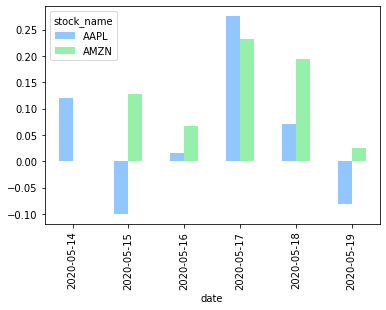

In [23]:
plt.style.use('seaborn-pastel')
%matplotlib inline

mean_data = total_company_data_frame.groupby(['date', 'stock_name']).mean()
mean_data = mean_data.unstack(level=1)
mean_data = mean_data.xs('compound', axis=1)
mean_data.plot.bar()

In [24]:
# Clean duplicates in headlines
dirty_headlines = total_company_data_frame.headlines.count()
cleaned_headlines = total_company_data_frame.drop_duplicates(['stock_name', 'headlines'])

In [25]:
print('Enter the name of the company you want to analyse')
print ('Allowed Values: ')
for index in range(num_companies):
    print(company_list[index])
company = input("Enter your option ")
date_to_analyse = input("Enter the date to analyse - (YYYY-MM-DD) ")

Enter the name of the company you want to analyse
Allowed Values: 
AMZN
AAPL
Enter your option AAPL
Enter the date to analyse - (YYYY-MM-DD) 2020-05-15


In [26]:
# Get data for single day of a stock to analyse the trend
single_day_data = cleaned_headlines.set_index(['stock_name', 'date'])
single_day_data = single_day_data.loc[company]

# Set day to January of 2019
single_day_data = single_day_data.loc[date_to_analyse]

# Convert the datetime string to just the time since it is just one day.
single_day_data['time'] = pd.to_datetime(single_day_data['time'])
single_day_data['time'] = single_day_data.time.dt.time
single_day_data
# Set the index to time and sort by it
single_day_data.set_index('time', inplace=True)
single_day_data = single_day_data.sort_index(ascending=True)
single_day_data.head()

,headlines,neg,neu,pos,compound
time,,,,,
00:00:00,Apple Confirms Acquisition Of Virtual Reality ...,0.0,1.000,0.000,0.0000
00:46:00,Pompeo says TSMC's $12 bln investment to incre...,0.0,0.839,0.161,0.3182
01:28:00,TSMC Plans $12 Billion U.S. Chip Plant in Vict...,0.0,1.000,0.000,0.0000
02:19:00,Foxconn's Q1 profit tumbles almost 90% on coro...,0.0,0.734,0.266,0.4404
05:28:00,IPhone Maker Foxconns Profit Gutted by Smartph...,0.0,0.707,0.293,0.4404


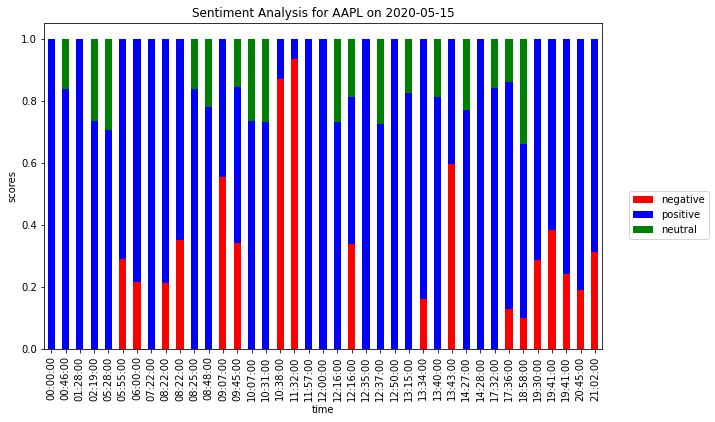

In [27]:
# Plot the sentiment scores
# Drop the columns which are useless
plot_day = single_day_data.drop(['headlines', 'compound'], axis=1)
# Give names to the sentiments
plot_day.columns = ['negative', 'positive', 'neutral']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True, 
                  figsize=(10, 6), 
                  title = 'Sentiment Analysis for ' + company + ' on ' + date_to_analyse, 
                  color = ["red", "blue", "green"])
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");